# Golf Shot Analysis



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplcursors as mplc

from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
import statsmodels.formula.api as smf

import glob
import os

import requests
from bs4 import BeautifulSoup

## The data

This is all real data collected using the Rapsodo MLM2Pro mobile launch monitor.

In [2]:
def read_all_files(folder_path, file_extension='csv'):

    all_files = glob.glob(os.path.join(folder_path, f"*.{file_extension}"))
    if not all_files:
        return pd.DataFrame()

    all_df = []
    for f in all_files:
        df = pd.read_csv(f)
        all_df.append(df)

    combined_df = pd.concat(all_df, ignore_index=True)
    return combined_df

In [3]:
folder_path = 'shot_csvs'
file_extension = 'csv'

df = read_all_files(folder_path, file_extension)
df.head()

,Date,Club Type,Club Description,Altitude,Club Speed,Ball Speed,Carry Distance,Total Distance,Roll Distance,Smash,...,Spin Rate,Spin Axis,Spin Reading,Low Point,Club Path,Face Path,Face Target,Swing Plane Tilt,Swing Plane Rotation,Shot Classification
0,NaN,NaN,NaN,[ft],[mph],[mph],[yd],[yd],[yd],NaN,...,[rpm],[deg],NaN,[in],[deg],[deg],[deg],[deg],[deg],NaN
1,2025-03-08 10:54:25,7 Iron,NaN,5600.00,77.85,93.95,140.69,157.56,16.86,1.21,...,4681,-11.50,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull Draw
2,2025-03-08 10:54:42,7 Iron,NaN,5600.00,78.29,101.56,155.21,170.88,15.67,1.30,...,5408,-6.80,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Draw
3,2025-03-08 10:55:21,7 Iron,NaN,5600.00,77.17,98.43,147.46,162.62,15.16,1.28,...,5842,2.60,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Straight
4,2025-03-08 10:55:43,7 Iron,NaN,5600.00,78.29,99.77,150.34,166.09,15.76,1.27,...,5783,-4.50,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    195 non-null    object 
 1   Club Type               195 non-null    object 
 2   Club Description        0 non-null      float64
 3   Altitude                197 non-null    object 
 4   Club Speed              197 non-null    object 
 5   Ball Speed              197 non-null    object 
 6   Carry Distance          197 non-null    object 
 7   Total Distance          197 non-null    object 
 8   Roll Distance           197 non-null    object 
 9   Smash                   195 non-null    float64
 10  Vertical Launch         197 non-null    object 
 11  Peak Height             197 non-null    object 
 12  Descent Angle           197 non-null    object 
 13  Horizontal Launch       197 non-null    object 
 14  Carry Lateral Distance  197 non-null    ob

In [5]:
df = df.drop(['Club Description', 'Attack Angle','Dynamic Loft', 'Attack Angle', 'Dynamic Loft', 
         'Spin Loft', 'Low Point' , 'Club Path', 'Face Path', 'Face Target' , 
         'Swing Plane Tilt', 'Swing Plane Rotation'], axis=1)
df.dropna(inplace=True)

df['Club Type'] = df['Club Type'].replace('Pitching Wedge', 'PW')


In [6]:
df['Club Color'] = 0.0

def assign_color(idx, row):
    if row['Club Type'] == '9 Iron':
        df.loc[idx, 'Club Color']  = 2.0
    elif row['Club Type'] == '8 Iron':
        df.loc[idx, 'Club Color'] = 3.0
    elif row['Club Type'] == '7 Iron':
        df.loc[idx, 'Club Color'] = 4.0
    elif row['Club Type'] == '6 Iron':
        df.loc[idx, 'Club Color'] = 5.0
    elif row['Club Type'] == '5 Iron':
        df.loc[idx, 'Club Color'] = 6.0
    elif row['Club Type'] == '4 Iron':
        df.loc[idx, 'Club Color'] = 7.0
    elif row['Club Type'] == '3 Iron':
        df.loc[idx, 'Club Color'] = 8.0
    elif row['Club Type'] == 'PW':
        df.loc[idx, 'Club Color'] = 1.0

for index, row in df.iterrows():
    assign_color(index, row)


In [7]:
df['Ball Speed'] = pd.to_numeric(df['Ball Speed'])
df['Carry Distance'] = pd.to_numeric(df['Carry Distance'])
df['Total Distance'] = pd.to_numeric(df['Total Distance'])
df['Carry Lateral Distance'] = pd.to_numeric(df['Carry Lateral Distance'])
df['Carry Curve Distance'] = pd.to_numeric(df['Carry Curve Distance'])
df['Peak Height'] = pd.to_numeric(df['Peak Height'])
df['Smash'] = pd.to_numeric(df['Smash'])

df['Club Type'].unique()


array(['7 Iron', '5 Iron', '9 Iron', '8 Iron', '6 Iron', '4 Iron', 'PW',
       '3 Iron'], dtype=object)

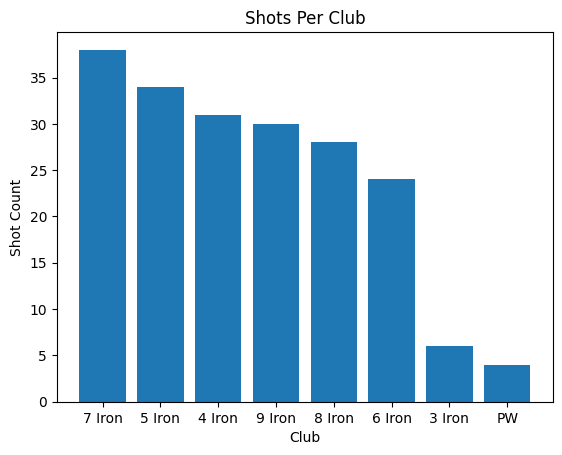

In [8]:
value_counts = df['Club Type'].value_counts()

value_counts

plt.bar(value_counts.index, value_counts)
plt.ylabel('Shot Count')
plt.xlabel('Club')
plt.title('Shots Per Club')

plt.show()

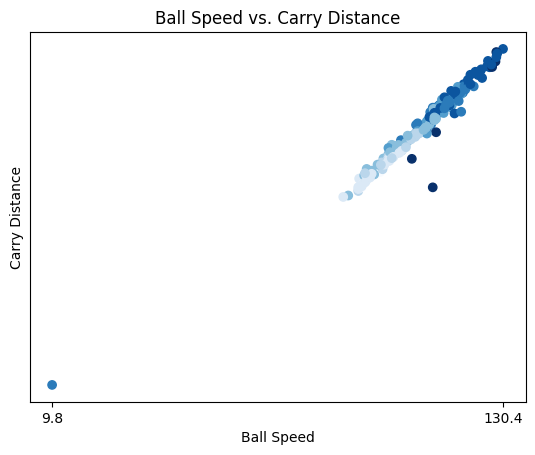

In [9]:
xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='Blues', label='Club Type')

max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()

plt.xticks([max_speed, min_speed])
plt.yticks([])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance')
plt.show()

Removing the one horrilble shank that had a ball speed of 9.8 mph

In [10]:
min_index = df['Carry Distance'].idxmin()
df = df.drop(min_index)

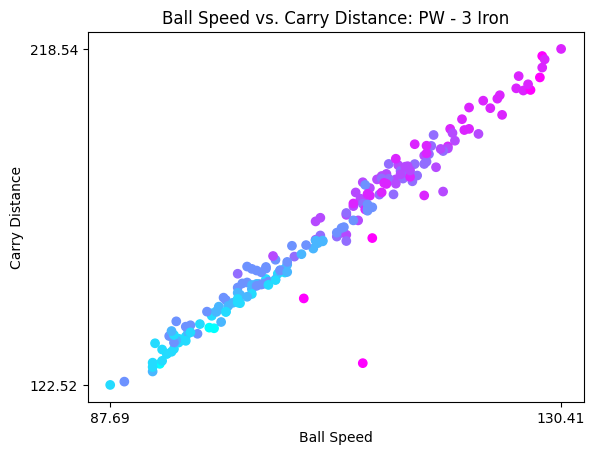

In [12]:
max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()
min_dist = df['Carry Distance'].min()

xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='cool', label='Club Type')

plt.xticks([max_speed, min_speed])
plt.yticks([min_dist, max_dist])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance: PW - 3 Iron')
plt.show()

Looks much better, now I will remove the 3 red outliers. My 3 iron broke during the data collection and these were the 2 shots prior to the club breaking and the 1 shot that the club head flew off of the shaft.

In [13]:
#remove the 3 3-iron outliers



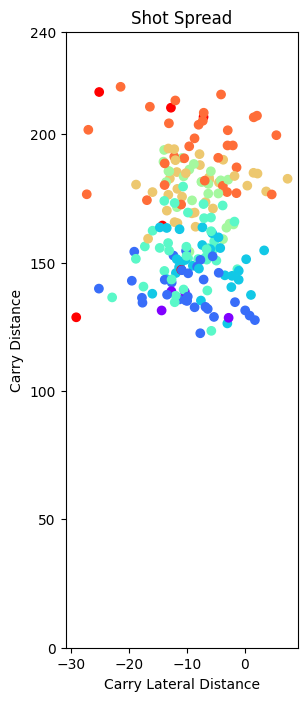

In [14]:
ypoints = df['Carry Distance']
xpoints = df['Carry Lateral Distance']


plt.figure(figsize=(3, 8))
plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='rainbow', label='Club Type')

#plt.xticks([max_speed, min_speed])
plt.yticks([0, 50, 100, 150,200,240])
plt.ylabel('Carry Distance')
plt.xlabel('Carry Lateral Distance')
plt.title('Shot Spread')
mplc.cursor(hover=True)
plt.show()

In [15]:
def getMeanDist(yardages):
    return yardages.mean()

mean_by_club = round(df.groupby('Club Type')['Carry Distance'].mean(), 2)
#mean_by_club.replace('Pitching Wedge', 'PW', inplace=True)
mean_by_club
mean_by_club = mean_by_club.rename({'Pitching Wedge': 'PW'}) 


In [16]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', bbox = dict(facecolor = 'skyblue', alpha =.7, mouseover=True))

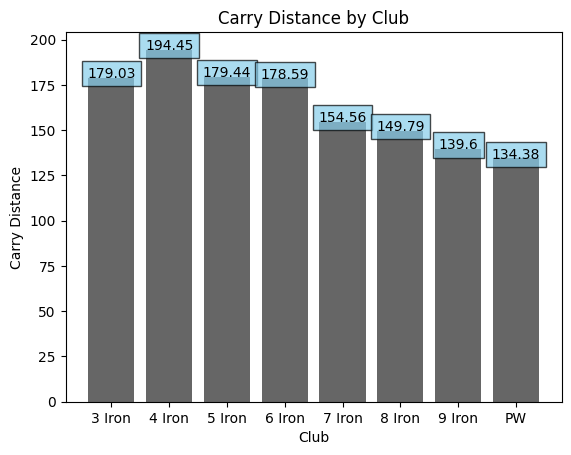

In [17]:
colors = plt.cm.Accent(df['Club Color'])
plt.bar(mean_by_club.index, mean_by_club.values, color=colors)
addlabels(mean_by_club.index, mean_by_club.values)
plt.ylabel('Carry Distance')
plt.xlabel('Club')
plt.title('Carry Distance by Club')
mplc.cursor(hover=True)
plt.show()


In [18]:
approach_data = {
    "shots": [25, 256,277,123],
    "greens hit": [8, 129, 178, 46],
    "inside 10": [2, 16,11,4],
    "distance": ["0-99", "100-149", "150-199", "200+"]
}

approach_df = pd.DataFrame(approach_data)

approach_df.head()


,shots,greens hit,inside 10,distance
0,25,8,2,0-99
1,256,129,16,100-149
2,277,178,11,150-199
3,123,46,4,200+


In [19]:
approach_df['green hit percent'] = round(approach_df['greens hit'] / approach_df['shots'], 2)
approach_df['inside 10 percent'] = round(approach_df['inside 10'] / approach_df['shots'], 2)

approach_df.head()

,shots,greens hit,inside 10,distance,green hit percent,inside 10 percent
0,25,8,2,0-99,0.32,0.08
1,256,129,16,100-149,0.50,0.06
2,277,178,11,150-199,0.64,0.04
3,123,46,4,200+,0.37,0.03


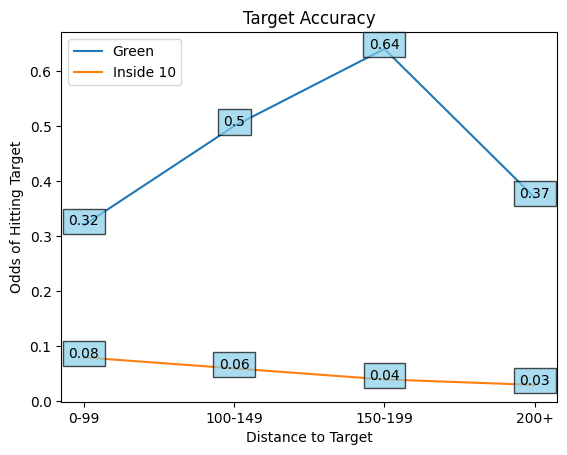

In [20]:
plt.plot(approach_df['distance'], approach_df['green hit percent'])
plt.plot(approach_df['distance'], approach_df['inside 10 percent'])
plt.xlabel('Distance to Target')
plt.ylabel('Odds of Hitting Target')
plt.title('Target Accuracy')
addlabels(approach_df['distance'], approach_df['green hit percent'])
addlabels(approach_df['distance'], approach_df['inside 10 percent'])
plt.legend(["Green", "Inside 10"], loc="upper left")
plt.show()

In [21]:
q1 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.25), 2)
q2 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.5), 2)
q3 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.75), 2)
q3

Club Type
3 Iron    209.50
4 Iron    204.82
5 Iron    184.89
6 Iron    185.66
7 Iron    162.43
8 Iron    156.01
9 Iron    146.03
PW        138.76
Name: Carry Distance, dtype: float64

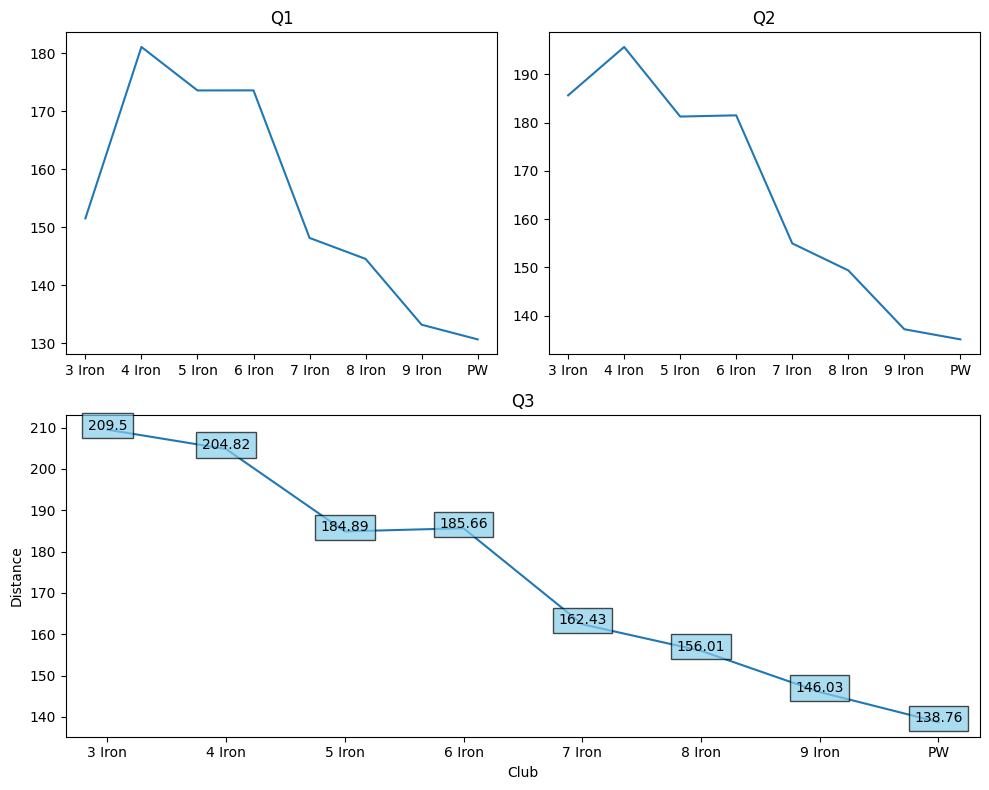

In [22]:
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.plot(q1.index, q1.values)
ax1.set_title('Q1')

ax2.plot(q2.index, q2.values)
ax2.set_title('Q2')

ax3.plot(q3.index, q3.values)
ax3.set_title('Q3')
ax3.set_ylabel('Distance')
ax3.set_xlabel('Club')
addlabels(q3.index, q3.values)

plt.tight_layout()
plt.show()

In [23]:
df.to_csv('shot_csvs/output/combined_and_cleaned.csv')

In [24]:
r = requests.get('https://www.golfmonthly.com/tour/how-far-pga-tour-players-hit-every-club-in-the-bag')

# check status code for response received
# success code - 200
print(r)

soup = BeautifulSoup(r.content, 'html.parser')

print('Classes of each table:')
for table in soup.find_all('table'):
    print(table.get('class'))

<Response [200]>
Classes of each table:
['table__wrapper', 'table__wrapper--inbodyContent', 'table__wrapper--sticky', 'table__wrapper--divider']


In [25]:
# Creating list with all tables
tables = soup.find_all('table')

#  Looking for the table with the classes 'wikitable' and 'sortable'
table = soup.find('table', class_='table__wrapper table__wrapper--inbodyContent table__wrapper--sticky table__wrapper--divider')

In [26]:
pro_df = pd.DataFrame(columns=['Club', 'Club Speed', 'Ball Speed', 'Spin Rate', 'Carry'])

club = []
club_speed = []
ball_speed = []
spin = []
carry = []

for row in table.tbody.find_all('tr'):    
    # Find all data for each column
    columns = row.find_all('td')
    
    if(columns != []):
        club.append(columns[0].text.strip())
        club_speed.append(columns[1].text.strip())
        ball_speed.append(columns[2].text.strip())
        spin.append(columns[3].text.strip())
        carry.append(columns[4].text.strip())

print(club)
pro_df['Club'] = club
pro_df['Club Speed'] = club_speed
pro_df['Ball Speed'] = ball_speed
pro_df['Spin Rate'] = spin
pro_df['Carry'] = carry

pro_df

['Driver', '3-Wood', '5-Wood', 'Hybrid', '3-Iron', '4-Iron', '5-Iron', '6-Iron', '7-Iron', '8-Iron', '9-Iron', 'Pitching Wedge']


,Club,Club Speed,Ball Speed,Spin Rate,Carry
0,Driver,115,171,2545,282
1,3-Wood,110,162,3663,249
2,5-Wood,106,156,4322,236
3,Hybrid,102,149,4587,231
4,3-Iron,100,145,4404,218
5,4-Iron,98,140,4782,209
6,5-Iron,96,135,5280,199
7,6-Iron,94,130,6204,188
8,7-Iron,92,123,7124,176
9,8-Iron,89,118,8078,164


In [27]:
pro_df['Club Speed'] = pd.to_numeric(pro_df['Club Speed'])
pro_df['Ball Speed'] = pd.to_numeric(pro_df['Ball Speed'])
pro_df['Spin Rate'] = pd.to_numeric(pro_df['Spin Rate'])
pro_df['Carry'] = pd.to_numeric(pro_df['Carry'])

pro_df.replace('3-Iron', '3 Iron', inplace=True)
pro_df.replace('4-Iron', '4 Iron', inplace=True)
pro_df.replace('5-Iron', '5 Iron', inplace=True)
pro_df.replace('6-Iron', '6 Iron', inplace=True)
pro_df.replace('7-Iron', '7 Iron', inplace=True)
pro_df.replace('8-Iron', '8 Iron', inplace=True)
pro_df.replace('9-Iron', '9 Iron', inplace=True)
pro_df.replace('Pitching Wedge', 'PW', inplace=True)

pro_df.drop(index=[0, 1, 2, 3], inplace=True)


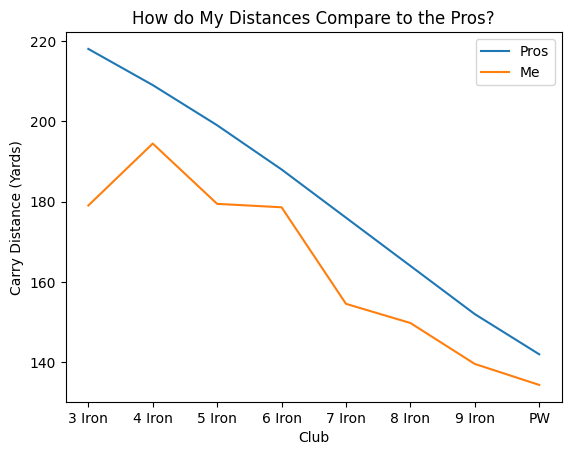

In [28]:
plt.plot(pro_df['Club'], pro_df['Carry'])
plt.plot(mean_by_club.index, mean_by_club.values)
plt.title('How do My Distances Compare to the Pros?')
plt.legend(['Pros', 'Me'])
plt.xlabel('Club')
plt.ylabel('Carry Distance (Yards)')
plt.show()